<div style="
    background-color: #ffe6f2;
    padding: 15px;
    border-radius: 10px;
    text-align: center;
    font-size: 24px;
    font-weight: bold;
    color: #333;
">
🍄 Taller de Aprendizaje Automático <br>
No Supervisado con el Dataset de Setas
</div>

In [10]:
# ============================================================
#  0. IMPORTACIÓN DE LIBRERÍAS
# ============================================================

# Librerías de sistema y manejo de datos
import os
import warnings
import pandas as pd
import numpy as np

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Funciones y modelos de Scikit-Learn
# Para descargar datasets de UCI
from ucimlrepo import fetch_ucirepo

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA                    # Reducción de dimensionalidad
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans                       # Clustering no supervisado
from sklearn.ensemble import RandomForestClassifier       # Modelo supervisado
from sklearn.model_selection import train_test_split      # División train/test
from sklearn.metrics import ( 
        accuracy_score, 
        confusion_matrix,
        adjusted_rand_score,
        normalized_mutual_info_score,
        classification_report,
        f1_score, 
)
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy import stats

warnings.filterwarnings("ignore")                         # Evita mostrar advertencias innecesarias
sns.set(style='whitegrid', context='notebook')
%matplotlib inline                           
RND = 42    # Semilla para reproducibilidad de resultados
print("Librerias y modulos importados exitosamente")


Librerias y modulos importados exitosamente


In [11]:
# ============================================================
#  1. CARGA Y EXPLORACIÓN DE DATOS
# ============================================================

def cargar_y_explorar_dataset():
    """
    Descarga el dataset de setas desde el repositorio UCI,
    realiza una exploración básica y devuelve el DataFrame.
    """

    print("📦 Descargando dataset 'Mushrooms' desde UCI Repository...")

    # Descarga automática del dataset con la función fetch_ucirepo
    mushroom = fetch_ucirepo(id=73)

    # Extraemos las características (X) y las etiquetas (y)
    X = mushroom.data.features
    y = mushroom.data.targets
    y.columns = ['class']                                 # Renombramos la columna de etiqueta como 'class'

    # Combinamos X e y en un único DataFrame
    df = pd.concat([y, X], axis=1)

    # Guardamos el dataset en formato CSV localmente
    os.makedirs("../data", exist_ok=True)
    path_csv = "../data/mushroom.csv"
    df.to_csv(path_csv, index=False)
    print(f"✅ Dataset guardado en '{path_csv}'.")

    # Cargamos nuevamente el CSV (verificación)
    df = pd.read_csv(path_csv)

    # Visualizamos las primeras filas para hacernos una idea general
    print("\n📊 Primeras filas del dataset:")
    display(df.head())

    # Información general del DataFrame
    print("\n📋 Información general del dataset:")
    print(df.info())

    # Dimensiones del dataset
    print(f"\nNúmero de filas: {df.shape[0]}")
    print(f"Número de columnas: {df.shape[1]}")

    # === Exploración adicional ===
    print("\n🔎 Conteo de valores nulos por columna:")
    print(df.isnull().sum())

    print("\n🔢 Número de valores únicos por columna:")
    print(df.nunique())

    # Gráfico de distribución de la variable objetivo (balance de clases)
    plt.figure(figsize=(5, 4))
    sns.countplot(x='class', data=df, palette='Set2')
    plt.title("Distribución de la variable objetivo (class)")
    plt.show()

    return df

In [12]:
# ============================================================
#  2. PREPROCESAMIENTO
# ============================================================

def preprocesamiento_datos(df: pd.DataFrame):
    """
    Limpieza y preparación del dataset para el modelado.
    Incluye imputación, codificación, escalado y separación X/y.
    """

    print("\n🧹 Iniciando preprocesamiento del dataset...")

    #  1. Eliminación de columnas sin información (constantes)
    cols_const = [c for c in df.columns if df[c].nunique() == 1]
    if cols_const:
        print(f"Eliminando columnas constantes: {cols_const}")
        df.drop(columns=cols_const, inplace=True)

    #  2. Imputación de valores faltantes (si existieran)
    if df.isnull().sum().sum() > 0:
        df.fillna("missing", inplace=True)
        print("Valores nulos imputados con 'missing'.")
    else:
        print("No se encontraron valores nulos.")

    #  3. Separación entre características (X) y variable objetivo (y)
    y = df['class']                       # Variable objetivo (e = comestible, p = venenoso)
    X = df.drop(columns=['class'])        # Resto de columnas = features

    #  4. Codificación de la variable objetivo en valores numéricos
    y = y.map({'e': 0, 'p': 1})           # e=0 (edible), p=1 (poisonous)

    #  5. One-Hot Encoding: convierte variables categóricas a binarias
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_encoded = pd.DataFrame(
        encoder.fit_transform(X),
        columns=encoder.get_feature_names_out(X.columns)
    )
    print(f"Codificación realizada: {X.shape[1]} columnas → {X_encoded.shape[1]} binarias.")

    #  6. Escalado (Estandarización con media=0, desviación=1)
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_encoded), columns=X_encoded.columns)
    # Agregamos la columna objetivo al dataset escalado
    X_scaled["class"] = y
    
   #  Construimos la ruta absoluta a la carpeta /data/
    output_path = os.path.join(os.path.dirname(os.getcwd()), "data", "mushroom_cleaned.csv")

   # Guardamos el CSV limpio
    X_scaled.to_csv(output_path, index=False)

    print(f"✅ Dataset limpio guardado en: {output_path}")

    print("✅ Dataset limpio guardado como 'data/mushrooms_cleaned.csv'.")

    return X_scaled, y


In [13]:
# ============================================================
#  3. PCA - ANÁLISIS DE COMPONENTES PRINCIPALES
# ============================================================

def aplicar_pca(X, y, n=2):
    """
    Aplica PCA para reducir la dimensionalidad a 'n' componentes principales
    y visualiza los resultados en 2D.
    """

    print(f"\n Aplicando PCA para reducir a {n} componentes principales...")

    # Inicializamos el modelo PCA
    pca = PCA(n_components=n, random_state=RND)

    # Ajustamos el modelo y transformamos los datos
    X_pca = pca.fit_transform(X)

    # Mostramos la varianza explicada por las componentes
    print(f"Varianza explicada total: {np.sum(pca.explained_variance_ratio_):.2%}")

    # Creamos un DataFrame con las nuevas dimensiones
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    df_pca['class'] = y.values

    # Visualizamos en 2D para ver si las clases son separables
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='class', palette='Set1', alpha=0.7)
    plt.title("Visualización 2D tras PCA (2 componentes principales)")
    plt.show()

    return X_pca

In [ ]:
# ============================================================
#  4. CLASIFICACIÓN SUPERVISADA (Random Forest) - Versión Mejorada
# ============================================================

def clasificacion_random_forest(X, y):
    """
    Entrena un modelo de Clasificación con Random Forest y genera
    un informe detallado de métricas y resultados.

    Incluye:
    - Accuracy global
    - Precision, Recall y F1 por clase
    - Matriz de confusión
    - Importancia de características
    - Análisis de errores
    - OOB Score (si se activa)
    """

    print("\n🌳 Entrenando modelo de Clasificación (Random Forest)...")

    # ============================================================
    # 1️. División del dataset en entrenamiento (70%) y prueba (30%)
    # ============================================================
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=RND, stratify=y
    )

    # ============================================================
    # 2️. Creación y entrenamiento del modelo Random Forest
    # ============================================================
    # n_estimators = número de árboles en el bosque
    # oob_score=True activa la validación Out-Of-Bag (similar a cross-validation)
    model = RandomForestClassifier(
        n_estimators=200,
        random_state=RND,
        oob_score=True,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    


    # ============================================================
    # 3️. Predicciones y métricas básicas
    # ============================================================
    y_pred = model.predict(X_test)

    # Accuracy global (porcentaje total de aciertos)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n Accuracy global: {acc:.4f}")
    # ============================================================
    # 3.1 Evaluación de Overfitting
    # ============================================================
    # Calculamos también el rendimiento del modelo en los datos de entrenamiento.
    y_train_pred = model.predict(X_train)
    acc_train = accuracy_score(y_train, y_train_pred)

    print("\n Evaluación de Overfitting:")
    print(f"Accuracy en entrenamiento: {acc_train:.4f}")
    print(f"Accuracy en prueba:        {acc:.4f}")
    print(f"Diferencia (train - test): {acc_train - acc:.4f}")

    # 🔍 Interpretación simple
    if acc_train - acc > 0.05:
        print("⚠️ Posible overfitting detectado: el modelo rinde mucho mejor en entrenamiento que en prueba.")
    else:
        print("✅ No se detecta overfitting significativo (modelo bien generalizado).")

    # ============================================================
    # 4️. Informe completo: Precision, Recall y F1 por clase
    # ============================================================
    print("\n📋 Informe de clasificación por clase:")
    print(classification_report(y_test, y_pred, target_names=["Comestible (0)", "Venenosa (1)"]))

    # ============================================================
    # 5️. Matriz de confusión
    # ============================================================
    print("\n Matriz de Confusión:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Visualización gráfica de la matriz
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=["Comestible", "Venenosa"], yticklabels=["Comestible", "Venenosa"])
    plt.title("Matriz de Confusión - Random Forest")
    plt.xlabel("Predicción")
    plt.ylabel("Clase Real")
    plt.show()

    # ============================================================
    # 6️. Importancia de características (Feature Importance)
    # ============================================================
    print("\n Importancia de las características (Feature Importance):")

    # Creamos un DataFrame ordenado con las variables más influyentes
    feature_importance = pd.DataFrame({
        'Característica': X.columns,
        'Importancia': model.feature_importances_
    }).sort_values(by='Importancia', ascending=False)

    display(feature_importance.head(10))  # Mostramos las 10 más relevantes
    
    #  Visualización de las 10 características más importantes (colores suaves)
    colores_suaves = [
                         "#FADADD", "#F6C5C0", "#F4A6A6", "#ECA1A6", "#E2B6CF",
                         "#CBAACB", "#D8A7B1", "#FFE5EC", "#FFD6E0", "#E2CFCF"
    ]

    # Visualización de las 10 más importantes
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=feature_importance.head(10),
        x='Importancia', y='Característica',
        palette=colores_suaves
    )
    plt.title("🔝 10 Características Más Importantes (Random Forest)")
    plt.show()

    # ============================================================
    # 7️. OOB Score (validación interna del modelo)
    # ============================================================
    print(f"\n OOB Score (Out-of-Bag accuracy): {model.oob_score_:.4f}")

    # ============================================================
    # 8️. Análisis de errores
    # ============================================================
    print("\n Análisis de Errores:")

    # Identificamos los índices donde el modelo se equivocó
    errores = X_test.copy()
    errores["Clase_real"] = y_test
    errores["Predicción"] = y_pred
    errores_filas = errores[errores["Clase_real"] != errores["Predicción"]]

    print(f"Total de errores: {len(errores_filas)} de {len(y_test)} muestras ({len(errores_filas)/len(y_test):.2%})")

    if not errores_filas.empty:
        print("\nEjemplo de algunos errores de clasificación:")
        display(errores_filas.head(5))
    else:
        print("✅ No se detectaron errores de clasificación en este conjunto de prueba.")

    # ============================================================
    # 9️. Resumen final del informe
    # ============================================================
    print("\n📑 RESUMEN FINAL DEL MODELO RANDOM FOREST")
    print("------------------------------------------------------")
    print(f"Accuracy global: {acc:.4f}")
    print(f"OOB Score: {model.oob_score_:.4f}")
    print(f"Errores detectados: {len(errores_filas)}")
    print("------------------------------------------------------")

    return {
        "modelo": model,
        "accuracy": acc,
        "oob_score": model.oob_score_,
        "importancias": feature_importance,
        "errores": errores_filas
    }


In [ ]:
# ============================================================
#  5. CLUSTERING CON K-MEANS
# ============================================================

def clustering_kmeans(X, y):
    """
    Aplica K-Means para agrupar los datos sin usar las etiquetas reales.
    Evalúa la correspondencia entre clusters y clases.
    """

    print("\n Iniciando clustering con K-Means...")

    # --- Determinación del número óptimo de clusters (Método del Codo) ---
    inertia = []  # Lista para almacenar la inercia (suma de distancias cuadradas)
    K = range(1, 10)

    for k in K:
        km = KMeans(n_clusters=k, random_state=RND, n_init=20)
        km.fit(X)
        inertia.append(km.inertia_)

    # Gráfica del método del codo
    plt.figure(figsize=(6, 4))
    plt.plot(K, inertia, marker='o')
    plt.title("Método del Codo para determinar K óptimo")
    plt.xlabel("Número de clusters (K)")
    plt.ylabel("Inercia")
    plt.show()

    # --- Elegimos K=2 porque el dataset tiene dos clases reales ---
    km = KMeans(n_clusters=2, random_state=RND, n_init=50)
    labels = km.fit_predict(X)

    # --- Evaluación del clustering ---
    # ARI y NMI comparan las etiquetas verdaderas con los clusters obtenidos
    ari = adjusted_rand_score(y, labels)
    nmi = normalized_mutual_info_score(y, labels)
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

    # Matriz de contingencia entre clases y clusters
    print("\n----------- Comparación entre clases reales y clusters --------------")
    print(pd.crosstab(y, labels, rownames=['Clase real'], colnames=['Cluster']))

    # Visualización 2D del clustering
    plt.figure(figsize=(7, 5))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title("Visualización de clusters K-Means")
    plt.xlabel("Componente 1 (PCA)")
    plt.ylabel("Componente 2 (PCA)")
    plt.show()

    return labels


=== 🚀 INICIO DEL TALLER DE MACHINE LEARNING NO SUPERVISADO ===
📦 Descargando dataset 'Mushrooms' desde UCI Repository...
✅ Dataset guardado en '../data/mushroom.csv'.

📊 Primeras filas del dataset:


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g



📋 Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   

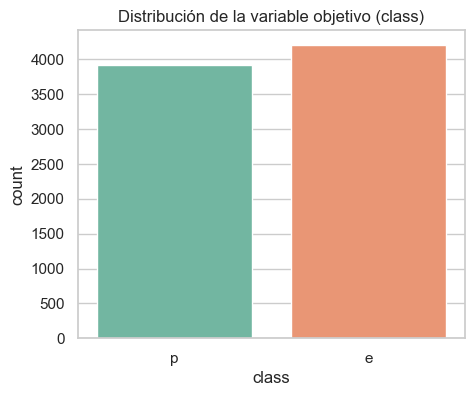


🧹 Iniciando preprocesamiento del dataset...
Eliminando columnas constantes: ['veil-type']
Valores nulos imputados con 'missing'.
Codificación realizada: 21 columnas → 116 binarias.
✅ Dataset limpio guardado en: c:\Users\alexi\LadyPFloresBerrocal-unsupervised-ml-workshop\data\mushroom_cleaned.csv
✅ Dataset limpio guardado como 'data/mushrooms_cleaned.csv'.

 Aplicando PCA para reducir a 2 componentes principales...
Varianza explicada total: 17.12%


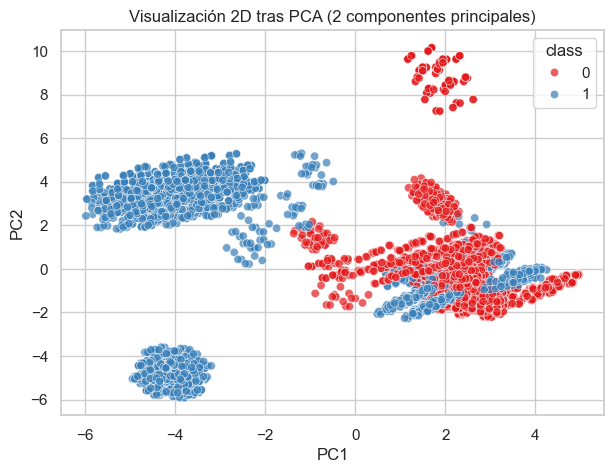


🌳 Entrenando modelo de Clasificación (Random Forest)...

✅ Accuracy global: 1.0000

📊 Evaluación de Overfitting:
Accuracy en entrenamiento: 1.0000
Accuracy en prueba:        1.0000
Diferencia (train - test): 0.0000
✅ No se detecta overfitting significativo (modelo bien generalizado).

📋 Informe de clasificación por clase:
                precision    recall  f1-score   support

Comestible (0)       1.00      1.00      1.00      1263
  Venenosa (1)       1.00      1.00      1.00      1175

      accuracy                           1.00      2438
     macro avg       1.00      1.00      1.00      2438
  weighted avg       1.00      1.00      1.00      2438


📊 Matriz de Confusión:
[[1263    0]
 [   0 1175]]


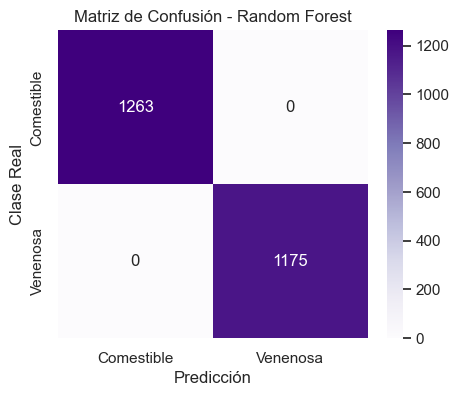


🌟 Importancia de las características (Feature Importance):


,Característica,Importancia
116,class,0.231608
27,odor_n,0.111198
24,odor_f,0.062542
36,gill-size_n,0.050490
61,stalk-surface-below-ring_k,0.045360
35,gill-size_b,0.042753
57,stalk-surface-above-ring_k,0.032141
95,spore-print-color_h,0.032140
37,gill-color_b,0.031872
20,bruises_f,0.024736


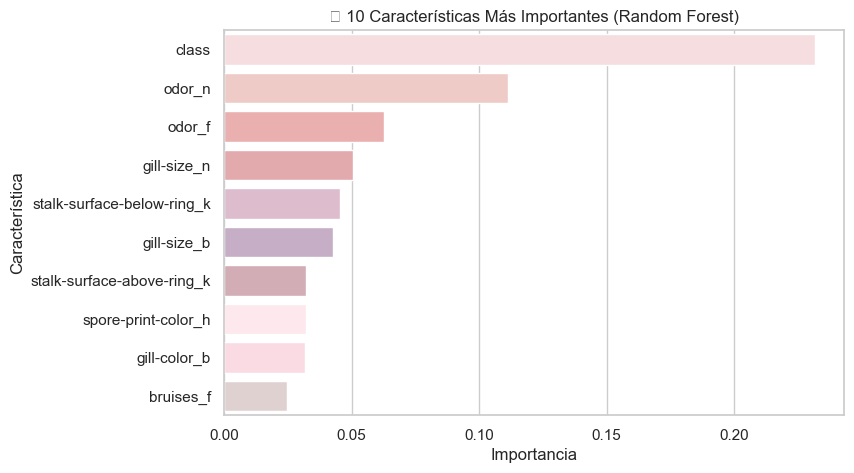


🧪 OOB Score (Out-of-Bag accuracy): 1.0000

🔎 Análisis de Errores:
Total de errores: 0 de 2438 muestras (0.00%)
✅ No se detectaron errores de clasificación en este conjunto de prueba.

📑 RESUMEN FINAL DEL MODELO RANDOM FOREST
------------------------------------------------------
Accuracy global: 1.0000
OOB Score: 1.0000
Errores detectados: 0
------------------------------------------------------

🔍 Iniciando clustering con K-Means...


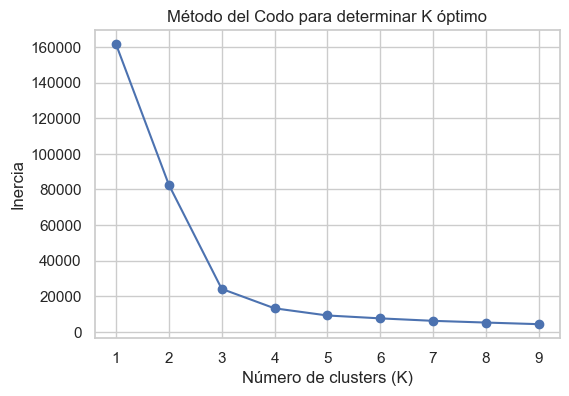

Adjusted Rand Index (ARI): 0.6182
Normalized Mutual Information (NMI): 0.5707

📊 Comparación entre clases reales y clusters:
Cluster        0     1
Clase real            
0           4161    47
1            821  3095


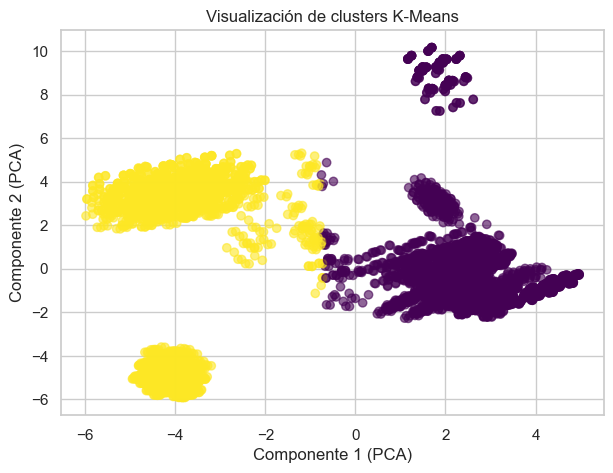


✅ TALLER COMPLETADO EXITOSAMENTE ✅
Revisa el archivo 'data/mushroom_cleaned.csv' y las gráficas generadas.


In [ ]:

# ============================================================
#   FLUJO PRINCIPAL DEL TALLER
# ============================================================

def main():
    print("===  INICIO DEL TALLER DE MACHINE LEARNING NO SUPERVISADO ===")

    # 1️⃣ Carga y exploración
    df = cargar_y_explorar_dataset()

    # 2️⃣ Preprocesamiento
    X_scaled, y = preprocesamiento_datos(df)

    # 3️⃣ PCA
    X_pca = aplicar_pca(X_scaled, y)

    # 4️⃣ Clasificación supervisada (Random Forest)
    clasificacion_random_forest(X_scaled, y)

    # 5️⃣ Clustering no supervisado (K-Means)
    clustering_kmeans(X_pca, y)

    print("\n✅ TALLER COMPLETADO EXITOSAMENTE ✅")
    print("Revisa el archivo 'data/mushroom_cleaned.csv' y las gráficas generadas.")


# ✅ Punto de entrada correcto del script
if __name__ == "__main__":
    main()



